In [1]:
import numpy as np

import torch

from timediffusion import TD

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Creating sequence data

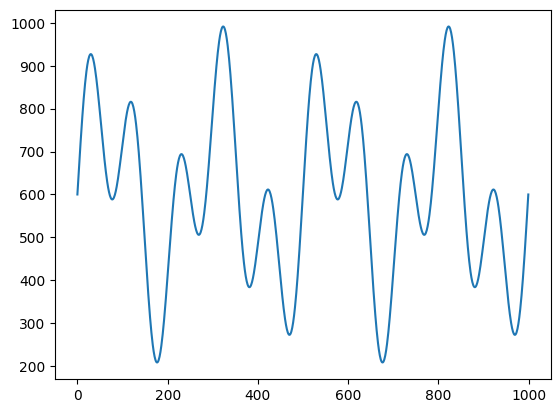

In [3]:
seq = np.sin(np.linspace(0, 20 * np.pi, 1_000)) + np.sin(np.linspace(0, 8 * np.pi, 1_000))
seq = seq * 200 + 600
seq = seq.reshape(1, - 1)
plt.plot(seq.flatten())
plt.show()

# Fit & Restore (Denoising | Showing how model fits into sequence)

100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


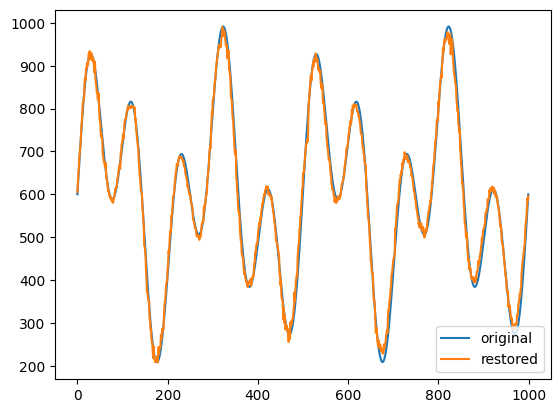

MAE distance between original and restored  1.5e+01


In [4]:
# providing input shape for model in format (channels, input sequence length)
model = TD(input_dims=seq.shape).to(device=device, dtype=torch.float32)

losses = model.fit(seq, verbose=True)

# restores from random noise
res = model.restore(shape=seq.shape)
res = res.cpu().numpy()

plt.plot(seq[0])
plt.plot(res[0])
plt.legend(["original", "restored"])
plt.show()

mae_dist = np.abs(res - seq).mean()
print(f"MAE distance between original and restored {mae_dist: .1e}")

# Fit masked & Restore with persistent reference (Imputation)

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


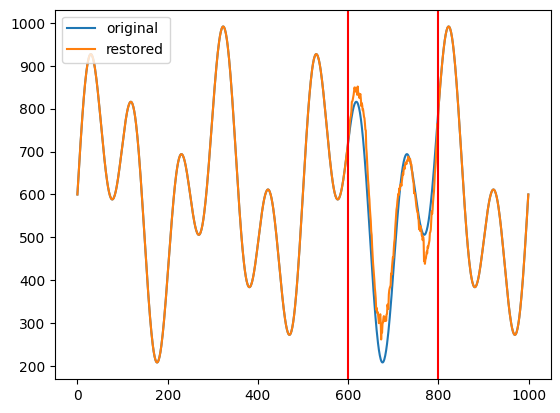

MAE distance between original and imputed  4.1e+01


In [5]:
# providing input shape for model in format (channels, input sequence length)
model = TD(input_dims=seq.shape).to(device=device, dtype=torch.float32)

mask = np.zeros_like(seq)
mask[:, 600: 800] = 1  # not fitting into points in range(600, 800)
seq_with_nans = seq.copy()
seq_with_nans[:, 600: 800] = np.nan
losses = model.fit(seq_with_nans, mask=mask, verbose=True)

# restores with reference (mask)
res = model.restore(example=seq_with_nans, mask=mask)
res = res.cpu().numpy()

plt.plot(seq[0])
plt.plot(res[0])
plt.axvline(x = 600, color = 'r')
plt.axvline(x = 800, color = 'r')
plt.legend(["original", "restored"])
plt.show()

mae_dist = np.abs(res - seq).sum() / mask.sum()
print(f"MAE distance between original and imputed {mae_dist: .1e}")

# Fit & Forecast

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


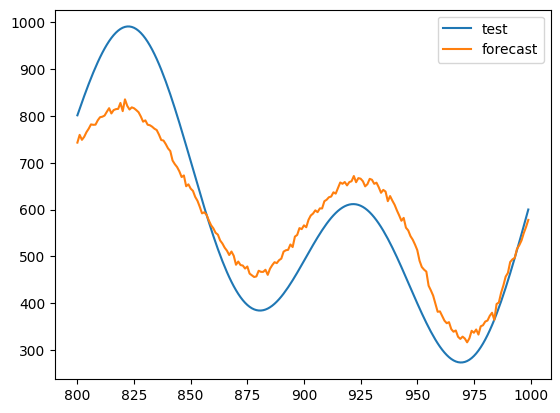

MAE test loss between test and forecast  7.9e+01


In [6]:
horizon = 200
train, test = seq[:, : - horizon], seq[:, - horizon:]

# providing input shape for model in format (channels, input sequence length)
model = TD(input_dims=train.shape).to(device=device, dtype=torch.float32)

losses = model.fit(train, verbose=True)

res = model.forecast(horizon)
res = res.cpu().numpy()

plt.plot(range(len(seq[0]) - horizon, len(seq[0])), test[0])
plt.plot(range(len(seq[0]) - horizon, len(seq[0])), res[0])
plt.legend(["test", "forecast"])
plt.show()

mae_dist = np.abs(test - res).mean()
print(f"MAE test loss between test and forecast {mae_dist: .1e}")

# Fit and Synth

In [7]:
# providing input shape for model in format (channels, input sequence length)
model = TD(input_dims=seq.shape).to(device=device, dtype=torch.float32)

losses = model.fit(seq, verbose=True)

100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


In [8]:
# step granulation gives better estimation as a tradeoff of speed
synthetic = model.synth(proximity=0.9, samples=3, batch_size=2, step_granulation=100, verbose=True)

Estimating fitted proximity...


100%|██████████| 3200/3200 [00:52<00:00, 61.49it/s]


Best granulated step is 80
Generating...


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


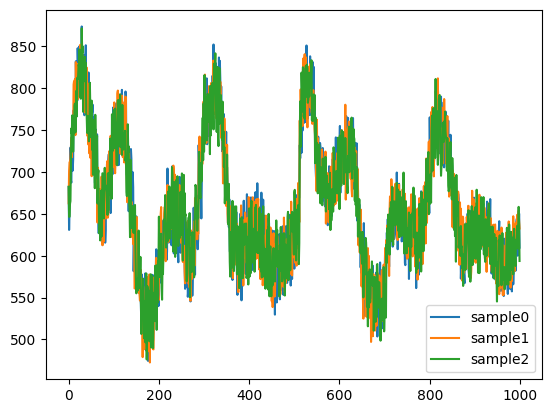

In [9]:
for s in synthetic:
    plt.plot(s.cpu().numpy().flatten())
plt.legend([f"sample{i}" for i in range(len(synthetic))])
plt.show()